<h2><b>Start</h2></b>

<h4><b>Script Documentation</h4></b>

Description and Use-Case: This code updates the main ReleaseIndex dataframe with the NfL data. It also has a few different visualization methods implemented in order to take a better look at the data. Use to create an updated ReleaseIndex, or to look at these different visualizations.

Process Workflow: \
Data Loading\
Step 1: Import necessary libraries and read CSV files into dataframes\
Initial Data Analysis/Validations:\
Step 2: Compute and print the size of unique patients of Release Index and NfL Data (Validation)\
Step 3: Subset Release Index and NfL dataframes to identify the number of control patients in each (Validation)\
Step 4: Identify patients in nfl but not in Release Index and print them. Handle special characters like \xa0 if present. (Validation)\
Data Cleaning and Validation:\
Step 5: Clean nfl DataFrame by removing rows where SubjID matches those not in Release Index.\
Step 6: Re-calculate nfl_patients after cleaning and identify patients still not in df. (Validation)\
Column Setup in Release Index:\
Step 7: Define a dictionary for new columns to be added to df. Add them in with a loop.\
Data Transfer from nfl to Release Index:\
Step 8: Initialize an empty dictionary (user_info) to store data for each nfl patient.\
Step 9: Iterate over unique nfl patients to populate user_info with timepoint and days data from nfl.\
Step 10: Handle any days-related issues in Days from Baseline during iteration. (Validation)\
Data Integration into Release Index:\
Step 11: Iterate over rows in df to match and integrate data from user_info for each patient.\
Step 12: Update columns in Release Index with corresponding data from user_info.\
Final Data Checks and Outputs:\
Step 13: Print value counts of Sample Timepoint in nfl and counts of non-NA/null entries for new_columns in df. (Validation)\
Step 14: Display the first few rows of the updated df to verify the integration of data and return a new csv for the merged data.\
Step 15: Combine SubjID and Sample Timepoint columns in nfl dataframe to check for duplicate values. (Validation)

---

### Execution
Import statements for pandas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Creates DataFrames, one for the Release Index, one for the updated NfL data, and one new one to be exported.

In [ ]:
nfl = pd.read_csv('2022.07_Biogen_MGH_NfL Test Results_Days from Baseline_External.csv')
df = pd.read_csv('ReleaseIndex_r6.5.csv')

Size comparison, we take the unique GUID's from the Release and NfL dataframes and check their sizes. Also checks the amount of control patients with NfL data, and creates empty arrays to be used later.

In [ ]:
#Size comparison
patients = df.GUID.unique()
nfl_patients = nfl.SubjID.unique()
not_in_patients = []
not_in_pat = []
nfl_ctrl_patients = []
print(f"Patients in ReleaseIndex: {patients.size}")  # 1269, correct
print(f"Patients in NFL Test Results: {nfl_patients.size}")  # 913, correct

ctrl_df = df[df['Participant_ID'].str.startswith('CTRL-')]
ctrl_patients = ctrl_df.GUID.unique()
print(f"Control Patients: {ctrl_patients.size}")  # 336, correct

for patient in ctrl_patients:
  if patient in nfl_patients:
    nfl_ctrl_patients.append(patient)
print(f"Control Patients in NFL Data: {len(nfl_ctrl_patients)}")  # 95

Patients in ReleaseIndex: 1269
Patients in NFL Test Results: 913
Control Patients: 336
Control Patients in NFL Data: 95


This returns all patient GUID's from the NfL dataset that are not in the ReleaseIndex. I removed the space from the uploaded NfL dataset here to make it easier, but the problem might be there if using this code on a different version.

In [ ]:
#Return all patients not in our main data set
for patient in nfl_patients:
  if patient not in patients:
    not_in_patients.append(patient)
print(not_in_patients) #['NEUBD027FAX\xa0', 'NEUKM143ZPE'], need to figure out where the \xa0 is from

['NEUBD027FAX\xa0', 'NEUKM143ZPE']


Check's for the space in the dataset, locates row. No longer necessary as I did it manually.

In [ ]:

#found problem from this code, was an extra space in the csv
#Only one row is not covered in our dataframe, I will remove the patient as they only have one timeslot associated with them
nfl['SubjID'] = nfl['SubjID'].str.replace('\xa0', '', regex=False)
print(nfl.iloc[147,:])

Study                                               NEUBD027FAX -4
SubjID                                                 NEUBD027FAX
Sample Timepoint                                                 4
Days from Baseline                                           252.0
Days from Baseline_Comment                                Estimate
Sample Type                                                  SERUM
Unnamed: 6                                                     NaN
Assay                         Seimens Atellica® Immunoassay  - NfL
Analyte                                                        NFL
Result Value                                                  11.6
Result Units                                                 pg/mL
Name: 147, dtype: object


Recheck that there are no users in the NfL dataset that are not in the ReleaseIndex.

In [ ]:
not_in_patients = [patient for patient in nfl.SubjID.unique() if patient not in patients]
print(f"Patients not in ReleaseIndex after cleaning: {not_in_patients}")

Patients not in ReleaseIndex after cleaning: ['NEUKM143ZPE']


Initialize all column titles for the new ReleaseIndex dataframe.

In [ ]:
#Set up column titles in ReleaseIndex
new_columns = {
    'HAS_NFL': pd.Series(dtype='object'),
    'Sample_Type': pd.Series(dtype='object'),
    'Assay': pd.Series(dtype='object'),
    'Analyte': pd.Series(dtype='object'),
    'NfL_Concentration_(pg/mL)_at_Timepoint-1': pd.Series(dtype='float64'),
    'NfL_Concentration_(pg/mL)_at_Timepoint-2': pd.Series(dtype='float64'),
    'NfL_Concentration_(pg/mL)_at_Timepoint-3': pd.Series(dtype='float64'),
    'NfL_Concentration_(pg/mL)_at_Timepoint-4': pd.Series(dtype='float64'),
    'NfL_Concentration_(pg/mL)_at_Timepoint-5': pd.Series(dtype='float64'),
    'Days_from_Baseline_Latest_Sample': pd.Series(dtype='float64'),
    'Days_from_Baseline_Comments': pd.Series(dtype='object'),
    'Number_of_Timepoints': pd.Series(dtype='object')
}

for column, dtype in new_columns.items():
    df[column] = dtype



#### Transfer the data over to the new Dataframe.

Does this by creating a dictionary of all GUID's and stores any associated data, like timepoints.

In [ ]:
#start to transfer information from NfL.csv to ReleaseIndex.csv
user_info = {}
days_problem = []
nfl_patient = nfl.SubjID.unique()

for user in nfl_patient:
  user_dict = {'Timepoint-1': np.nan, 'Timepoint-2': np.nan, 'Timepoint-3': np.nan, 'Timepoint-4': np.nan, 'Timepoint-5': np.nan, 'Days': np.nan, 'Comment': np.nan, 'Num_Timepoints': np.nan}
  user_rows = nfl[nfl['SubjID'] == user]
  num_time = 0
  #above part creates a dictionary that can store any value I need to transfer in one line

  #below separates each users rows and stores any values for each timepoint
  for index, row in user_rows.iterrows():
    #Timepoint and timepoint value storage. Adds days from baseline and checks if larger than what is already stored
    value = row['Result Value']


    if row['Sample Timepoint'] == 1:
      user_dict['Timepoint-1'] = value
      num_time += 1
    elif row['Sample Timepoint'] == 2:
      user_dict['Timepoint-2'] = value
      num_time += 1
    elif row['Sample Timepoint'] == 3:
      user_dict['Timepoint-3'] = value
      num_time += 1
    elif row['Sample Timepoint'] == 4:
      user_dict['Timepoint-4'] = value
      num_time += 1
    elif row['Sample Timepoint'] == 5:
      user_dict['Timepoint-5'] = value
      num_time += 1

    if np.isnan(user_dict['Days']) or row['Days from Baseline'] > user_dict['Days']:
      user_dict['Days'] = row['Days from Baseline']
      if row['Days from Baseline_Comment'] == 'Estimate':
        user_dict['Comment'] = 'Estimate'
      else:
        user_dict['Comment'] = np.nan

    user_dict['Num_Timepoints'] = num_time



  #add the user to out main dictionary
  user_info[user] = user_dict
#print(user_info)

df.head()

,Participant_ID,GUID,NYGC_CGND_ID,HAS_GENOMICS,HAS_EPIGENOMICS,HAS_TRANSCRIPTOMICS,HAS_PROTEOMICS,HAS_NFL,NFL_TIMEPOINTS_AVAILABLE,HAS_SOMASCAN,...,Assay,Analyte,NfL_Concentration_(pg/mL)_at_Timepoint-1,NfL_Concentration_(pg/mL)_at_Timepoint-2,NfL_Concentration_(pg/mL)_at_Timepoint-3,NfL_Concentration_(pg/mL)_at_Timepoint-4,NfL_Concentration_(pg/mL)_at_Timepoint-5,Days_from_Baseline_Latest_Sample,Days_from_Baseline_Comments,Number_of_Timepoints
0,CASE-NEUAA295HHE,NEUAA295HHE,CGND-HDA-03247,Yes,Yes,NaN,Yes,NaN,NaN,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CASE-NEUAA599TMX,NEUAA599TMX,CGND-HDA-00461,Yes,Yes,Yes,Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CASE-NEUAB000NKC,NEUAB000NKC,CGND-HDA-00583,Yes,Yes,Yes,Yes,NaN,NaN,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CASE-NEUAC617GR5,NEUAC617GR5,CGND-HDA-01346,Yes,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CASE-NEUAD142RRY,NEUAD142RRY,CGND-HDA-03231,Yes,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Used to input the new data to the Dataframe from the dictionary. Does this for each GUID.

In [ ]:
# Check for each user's information and store it on their line from dictionary
for index, row in df.iterrows():
    row_guid = row['GUID']
    if row_guid in nfl_patients:
        info = user_info[row_guid]
        timepoints_available = []
        updates = {
            'HAS_NFL': 'Yes',
            'Sample_Type': 'SERUM',
            'Assay': 'Seimens Atellica Immunoassay - NfL',
            'Analyte': 'NFL',
            'Days_from_Baseline_Latest_Sample': info['Days'],
            'Days_from_Baseline_Comments': info['Comment']
        }
        for tp in range(1, 6):
            tp_key = f'Timepoint-{tp}'
            nfl_conc_col = f'NfL_Concentration_(pg/mL)_at_Timepoint-{tp}'
            tp_value = info.get(tp_key)
            updates[nfl_conc_col] = tp_value
            if pd.notnull(tp_value):
                timepoints_available.append(str(tp))
        updates['NFL_TIMEPOINTS_AVAILABLE'] = ', '.join(timepoints_available)
        df.loc[index, updates.keys()] = updates.values()

# Check value counts for nfl data and then transferred data
print(nfl['Sample Timepoint'].value_counts())
new_columns = [
    'HAS_NFL',
    'Sample_Type',
    'Assay',
    'Analyte',
    'NfL_Concentration_(pg/mL)_at_Timepoint-1',
    'NfL_Concentration_(pg/mL)_at_Timepoint-2',
    'NfL_Concentration_(pg/mL)_at_Timepoint-3',
    'NfL_Concentration_(pg/mL)_at_Timepoint-4',
    'NfL_Concentration_(pg/mL)_at_Timepoint-5',
    'Days_from_Baseline_Latest_Sample',
    'Days_from_Baseline_Comments',
    'NFL_TIMEPOINTS_AVAILABLE'
]
non_nan_counts = df[new_columns].count()
print(non_nan_counts)

# Drop specified columns
drop_columns = [
    'Sample_Type',
    'Assay',
    'Analyte',
    'NfL_Concentration_(pg/mL)_at_Timepoint-1',
    'NfL_Concentration_(pg/mL)_at_Timepoint-2',
    'NfL_Concentration_(pg/mL)_at_Timepoint-3',
    'NfL_Concentration_(pg/mL)_at_Timepoint-4',
    'NfL_Concentration_(pg/mL)_at_Timepoint-5',
    'Days_from_Baseline_Latest_Sample',
    'Days_from_Baseline_Comments'
]
df_output = df.drop(drop_columns, axis=1)


<ipython-input-9-4ec979c02b09>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '64.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, updates.keys()] = updates.values()
<ipython-input-9-4ec979c02b09>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '62.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, updates.keys()] = updates.values()
<ipython-input-9-4ec979c02b09>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '46.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, updates.keys()] = updates.values()
<ipython-input-9-4ec979c02b09>:23: FutureWarning: Setting an item of i

Sample Timepoint
1    748
2    459
3    321
4    235
5    183
Name: count, dtype: int64
HAS_NFL                                     911
Sample_Type                                 911
Assay                                       911
Analyte                                     911
NfL_Concentration_(pg/mL)_at_Timepoint-1    747
NfL_Concentration_(pg/mL)_at_Timepoint-2    459
NfL_Concentration_(pg/mL)_at_Timepoint-3    321
NfL_Concentration_(pg/mL)_at_Timepoint-4    235
NfL_Concentration_(pg/mL)_at_Timepoint-5    183
Days_from_Baseline_Latest_Sample            911
Days_from_Baseline_Comments                  60
NFL_TIMEPOINTS_AVAILABLE                    911
dtype: int64


In [ ]:
# #Check for each users information and store it on their line from dictionary
# for index, row in df.iterrows():
#   row_guid = row['GUID']
#   if row_guid in nfl_patients:
#     info = user_info[row_guid]
#     df.loc[index, 'HAS_NFL'] = 'Yes'
#     df.loc[index, 'Sample_Type'] = 'SERUM'
#     df.loc[index, 'Assay'] = 'Seimens Atellica Immunoassay - NfL'
#     df.loc[index, 'Analyte'] = 'NFL'
#     df.loc[index, 'NfL_Concentration_(pg/mL)_at_Timepoint-1'] = info['Timepoint-1']
#     df.loc[index, 'NfL_Concentration_(pg/mL)_at_Timepoint-2'] = info['Timepoint-2']
#     df.loc[index, 'NfL_Concentration_(pg/mL)_at_Timepoint-3'] = info['Timepoint-3']
#     df.loc[index, 'NfL_Concentration_(pg/mL)_at_Timepoint-4'] = info['Timepoint-4']
#     df.loc[index, 'NfL_Concentration_(pg/mL)_at_Timepoint-5'] = info['Timepoint-5']
#     df.loc[index, 'Days_from_Baseline_Latest_Sample'] = info['Days']
#     df.loc[index, 'Number_of_Timepoints'] = info['Num_Timepoints']
#     df.loc[index, 'Days_from_Baseline_Comments'] = info['Comment']

# #check value counts for nfl data and then transfered data
# print(nfl['Sample Timepoint'].value_counts())
# new_columns = [
#     'HAS_NFL',
#     'Sample_Type',
#     'Assay',
#     'Analyte',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-1',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-2',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-3',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-4',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-5',
#     'Days_from_Baseline_Latest_Sample',
#     'Days_from_Baseline_Comments'
# ]
# non_nan_counts = df[new_columns].count()
# print(non_nan_counts)

# non_na_count = df['Number_of_Timepoints'].apply(lambda x: x != 'Na').sum()
# print(f"Non-Na count for 'Number_of_Timepoints': {non_na_count}")

# drop_columns = [
#     'Sample_Type',
#     'Assay',
#     'Analyte',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-1',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-2',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-3',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-4',
#     'NfL_Concentration_(pg/mL)_at_Timepoint-5',
#     'Days_from_Baseline_Latest_Sample',
#     'Days_from_Baseline_Comments'
# ]
# df_output = df.drop(drop_columns, axis=1)


Change types to origional and store output df

In [ ]:
def convert_to_int32_with_nan(series):
    placeholder = -99999
    series_filled = series.fillna(placeholder)
    series_int = series_filled.astype(np.int32)
    series_int[series_int == placeholder] = np.nan
    return series_int

df_output['Number_of_Visits'] = convert_to_int32_with_nan(df['Number_of_Visits'])
df_output['AGE_AT_SYMPTOM_ONSET'] = convert_to_int32_with_nan(df['AGE_AT_SYMPTOM_ONSET'])




output_filepath = f'/content/ReleaseIndex_updated_with_NfL.csv'
df_output.to_csv(output_filepath, index=False)
df_output.head()

,Participant_ID,GUID,NYGC_CGND_ID,HAS_GENOMICS,HAS_EPIGENOMICS,HAS_TRANSCRIPTOMICS,HAS_PROTEOMICS,HAS_NFL,NFL_TIMEPOINTS_AVAILABLE,HAS_SOMASCAN,...,ClinReport_Mutations_Details,HasVariant,EH_C9orf72,EH_ATXN2,C9orf72_repeat_length,ATXN2_repeat_length,WGS_Sequencing_Protocol_Used,Genomic_Sequencing_DNA_Source,External_Control,Number_of_Timepoints
0,CASE-NEUAA295HHE,NEUAA295HHE,CGND-HDA-03247,Yes,Yes,NaN,Yes,Yes,"2, 4, 5",Yes,...,NaN,NaN,Yes,Yes,2.0,22.0,TruSeq PCR-Free,Blood,No,NaN
1,CASE-NEUAA599TMX,NEUAA599TMX,CGND-HDA-00461,Yes,Yes,Yes,Yes,Yes,"1, 2",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,TruSeq Nano PCR amplificaton,Blood,No,NaN
2,CASE-NEUAB000NKC,NEUAB000NKC,CGND-HDA-00583,Yes,Yes,Yes,Yes,Yes,"1, 3, 4",Yes,...,C9orf72,NaN,NaN,NaN,NaN,NaN,TruSeq Nano PCR amplificaton,Blood,No,NaN
3,CASE-NEUAC617GR5,NEUAC617GR5,CGND-HDA-01346,Yes,NaN,NaN,NaN,Yes,"1, 4",NaN,...,NaN,NaN,Yes,Yes,14.0,22.0,TruSeq PCR-Free,Blood,No,NaN
4,CASE-NEUAD142RRY,NEUAD142RRY,CGND-HDA-03231,Yes,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Yes,Yes,2.0,22.0,TruSeq PCR-Free,Blood,No,NaN


Validation that there are no duplicate timepoints for the same GUID in NfL data.


In [ ]:
concatenated_columns = pd.concat([nfl['SubjID'], nfl['Sample Timepoint']], axis=1)
duplicates = concatenated_columns.duplicated()
print(f"Number of Duplicate Timepoints Found: {duplicates.sum()}")


Number of Duplicate Timepoints Found: 0


Validate that the days from baseline comments are working

In [ ]:
print(df[df['GUID'] == 'NEUAK082KC4']) #Estimate at last timepoint
print(df[df['GUID'] == 'NEUAT985UWC']) #Estimate at second to last timepoint

        Participant_ID         GUID    NYGC_CGND_ID HAS_GENOMICS  \
1149  CTRL-NEUAK082KC4  NEUAK082KC4  CGND-HDA-03152          Yes   

     HAS_EPIGENOMICS HAS_TRANSCRIPTOMICS HAS_PROTEOMICS HAS_NFL  \
1149             NaN                 NaN            NaN     Yes   

     NFL_TIMEPOINTS_AVAILABLE HAS_SOMASCAN  ...  \
1149                     1, 2          Yes  ...   

                                   Assay  Analyte  \
1149  Seimens Atellica Immunoassay - NfL      NFL   

     NfL_Concentration_(pg/mL)_at_Timepoint-1  \
1149                                     18.3   

     NfL_Concentration_(pg/mL)_at_Timepoint-2  \
1149                                     16.1   

     NfL_Concentration_(pg/mL)_at_Timepoint-3  \
1149                                      NaN   

     NfL_Concentration_(pg/mL)_at_Timepoint-4  \
1149                                      NaN   

     NfL_Concentration_(pg/mL)_at_Timepoint-5  \
1149                                      NaN   

     Days_from_Baseline

Separate patients into different bins to be used for visualizations later

In [ ]:
#Create bins for control patients of not, have ctrl_df from earlier
case_df = df[~df['Participant_ID'].str.startswith('CTRL-')]
ctrl_df = df[df['Participant_ID'].str.startswith('CTRL-')]



Return a list of all control patients with more than 1 timepoint.

In [ ]:
ctrl_df['Number_of_Timepoints'] = pd.to_numeric(ctrl_df['Number_of_Timepoints'], errors='coerce')
ctrl_patients_more_than_1 = ctrl_df[ctrl_df['Number_of_Timepoints'] > 1]['GUID'].unique()
print(f"Control patients with more than 1 timepoint: {ctrl_patients_more_than_1}")

Control patients with more than 1 timepoint: []


<ipython-input-15-12cd04afe7df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl_df['Number_of_Timepoints'] = pd.to_numeric(ctrl_df['Number_of_Timepoints'], errors='coerce')


Plot timepoint data for all patients on line graph

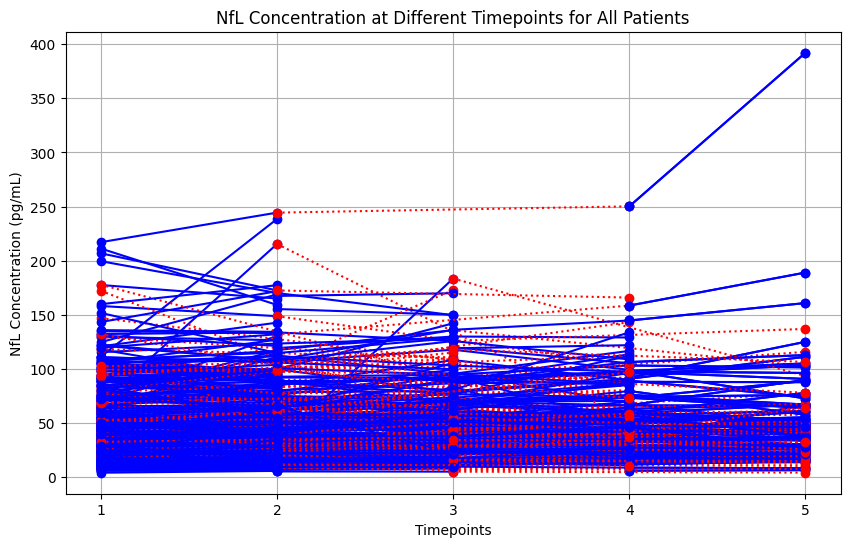

In [ ]:
timepoints_line = [
    'NfL_Concentration_(pg/mL)_at_Timepoint-1',
    'NfL_Concentration_(pg/mL)_at_Timepoint-2',
    'NfL_Concentration_(pg/mL)_at_Timepoint-3',
    'NfL_Concentration_(pg/mL)_at_Timepoint-4',
    'NfL_Concentration_(pg/mL)_at_Timepoint-5'
]

plt.figure(figsize=(10, 6))

for index, row in df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')
        timepoints = range(1, 6)

        for i in range(len(numeric_values) - 1):
            if pd.notna(numeric_values[i]) and pd.notna(numeric_values[i + 1]):
                plt.plot(timepoints[i:i+2], numeric_values[i:i+2], marker='o', linestyle='-', color='b')
            elif pd.notna(numeric_values[i]) and pd.isna(numeric_values[i + 1]) and i < len(numeric_values) - 2 and pd.notna(numeric_values[i + 2]):
                plt.plot(timepoints[i:i+3:2], [numeric_values[i], numeric_values[i + 2]], marker='o', linestyle=':', color='r')

        # Plot the last segment if it exists
        if pd.notna(numeric_values[-1]) and pd.notna(numeric_values[-2]):
            plt.plot(timepoints[-2:], numeric_values[-2:], marker='o', linestyle='-', color='b')

plt.title('NfL Concentration at Different Timepoints for All Patients')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

Visualization of only users missing a datapoint to show the dotted lines


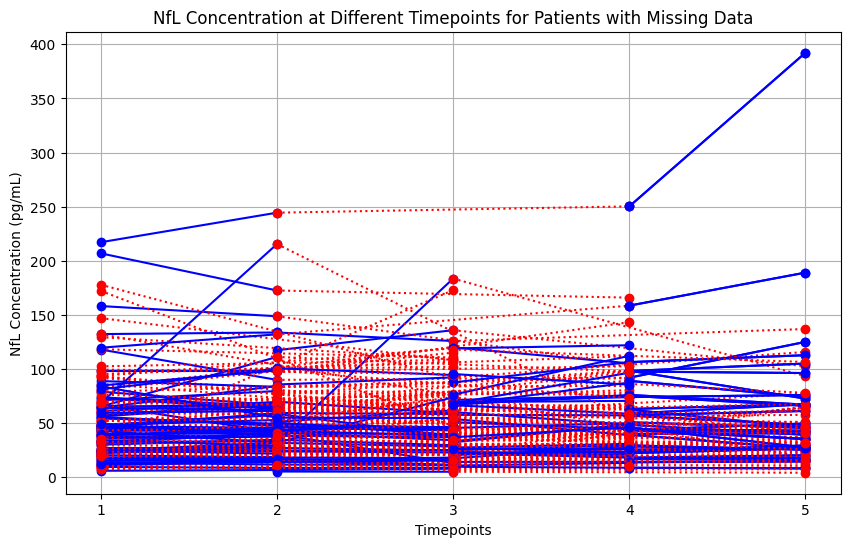

In [ ]:
plt.figure(figsize=(10, 6))

for index, row in df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')

        # Check if the user has any missing data in between timepoints
        has_dotted_line = any(pd.isna(numeric_values[i]) and pd.notna(numeric_values[i - 1]) and pd.notna(numeric_values[i + 1])
                              for i in range(1, len(numeric_values) - 1))

        if has_dotted_line:
            timepoints = range(1, 6)

            for i in range(len(numeric_values) - 1):
                if pd.notna(numeric_values[i]) and pd.notna(numeric_values[i + 1]):
                    plt.plot(timepoints[i:i+2], numeric_values[i:i+2], marker='o', linestyle='-', color='b')
                elif pd.notna(numeric_values[i]) and pd.isna(numeric_values[i + 1]) and i < len(numeric_values) - 2 and pd.notna(numeric_values[i + 2]):
                    plt.plot(timepoints[i:i+3:2], [numeric_values[i], numeric_values[i + 2]], marker='o', linestyle=':', color='r')

            # Plot the last segment if it exists
            if pd.notna(numeric_values[-1]) and pd.notna(numeric_values[-2]):
                plt.plot(timepoints[-2:], numeric_values[-2:], marker='o', linestyle='-', color='b')

plt.title('NfL Concentration at Different Timepoints for Patients with Missing Data')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

Plot timepoint data for all patients with 3 or more timepoints on line graph

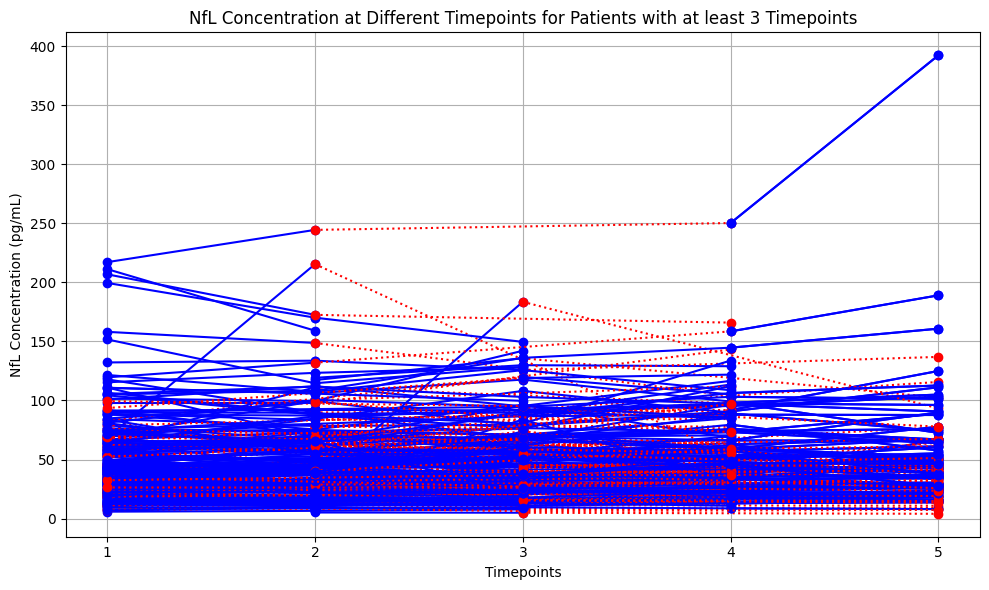

In [ ]:
patients_with_at_least_3_timepoints = df[df[timepoints_line].apply(lambda x: x.count(), axis=1) >= 3]['GUID']
filtered_df = df[df['GUID'].isin(patients_with_at_least_3_timepoints)]

plt.figure(figsize=(10, 6))

for index, row in filtered_df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')
        timepoints = range(1, 6)

        for i in range(len(numeric_values) - 1):
            if pd.notna(numeric_values[i]) and pd.notna(numeric_values[i + 1]):
                plt.plot(timepoints[i:i+2], numeric_values[i:i+2], marker='o', linestyle='-', color='b')
            elif pd.notna(numeric_values[i]) and pd.isna(numeric_values[i + 1]) and i < len(numeric_values) - 2 and pd.notna(numeric_values[i + 2]):
                plt.plot(timepoints[i:i+3:2], [numeric_values[i], numeric_values[i + 2]], marker='o', linestyle=':', color='r')

        # Plot the last segment if it exists
        if pd.notna(numeric_values[-1]) and pd.notna(numeric_values[-2]):
            plt.plot(timepoints[-2:], numeric_values[-2:], marker='o', linestyle='-', color='b')

plt.title('NfL Concentration at Different Timepoints for Patients with at least 3 Timepoints')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

Line graph of all control patients

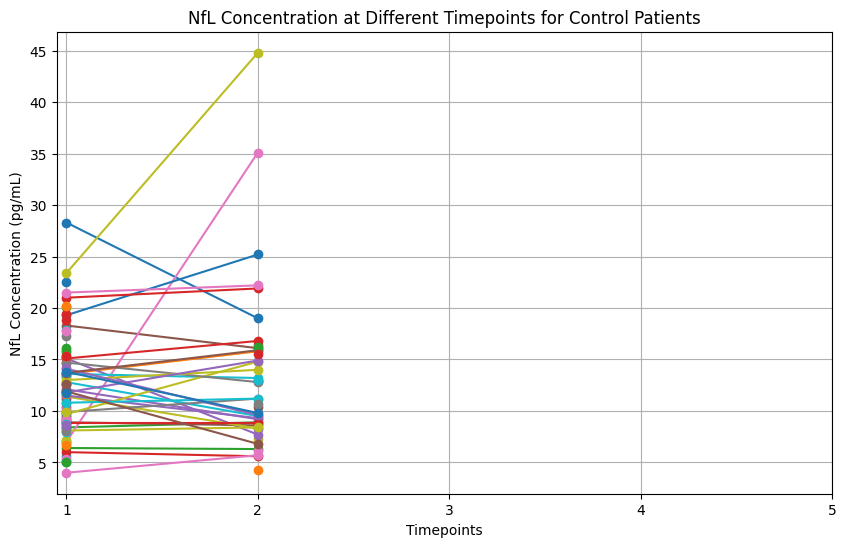

In [ ]:
plt.figure(figsize=(10, 6))

for index, row in ctrl_df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        # Convert values to numeric, coercing errors and ignoring non-numeric values
        numeric_values = pd.to_numeric(values, errors='coerce')
        plt.plot(range(1, 6), numeric_values, marker='o')

plt.title('NfL Concentration at Different Timepoints for Control Patients')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

Creates a line graph for all non-control patients

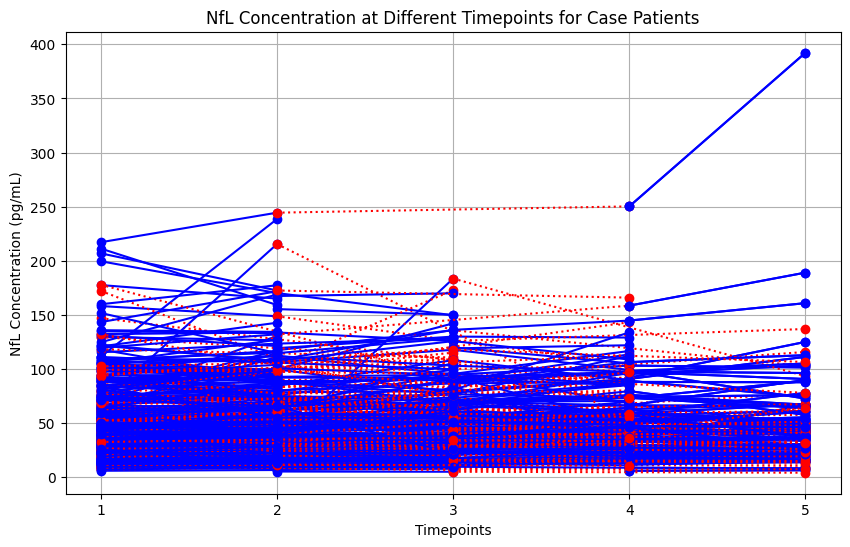

In [ ]:
plt.figure(figsize=(10, 6))

for index, row in case_df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')
        timepoints = range(1, 6)

        for i in range(len(numeric_values) - 1):
            if pd.notna(numeric_values[i]) and pd.notna(numeric_values[i + 1]):
                plt.plot(timepoints[i:i+2], numeric_values[i:i+2], marker='o', linestyle='-', color='b')
            elif pd.notna(numeric_values[i]) and pd.isna(numeric_values[i + 1]) and i < len(numeric_values) - 2 and pd.notna(numeric_values[i + 2]):
                plt.plot(timepoints[i:i+3:2], [numeric_values[i], numeric_values[i + 2]], marker='o', linestyle=':', color='r')

        # Plot the last segment if it exists
        if pd.notna(numeric_values[-1]) and pd.notna(numeric_values[-2]):
            plt.plot(timepoints[-2:], numeric_values[-2:], marker='o', linestyle='-', color='b')


plt.title('NfL Concentration at Different Timepoints for Case Patients')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

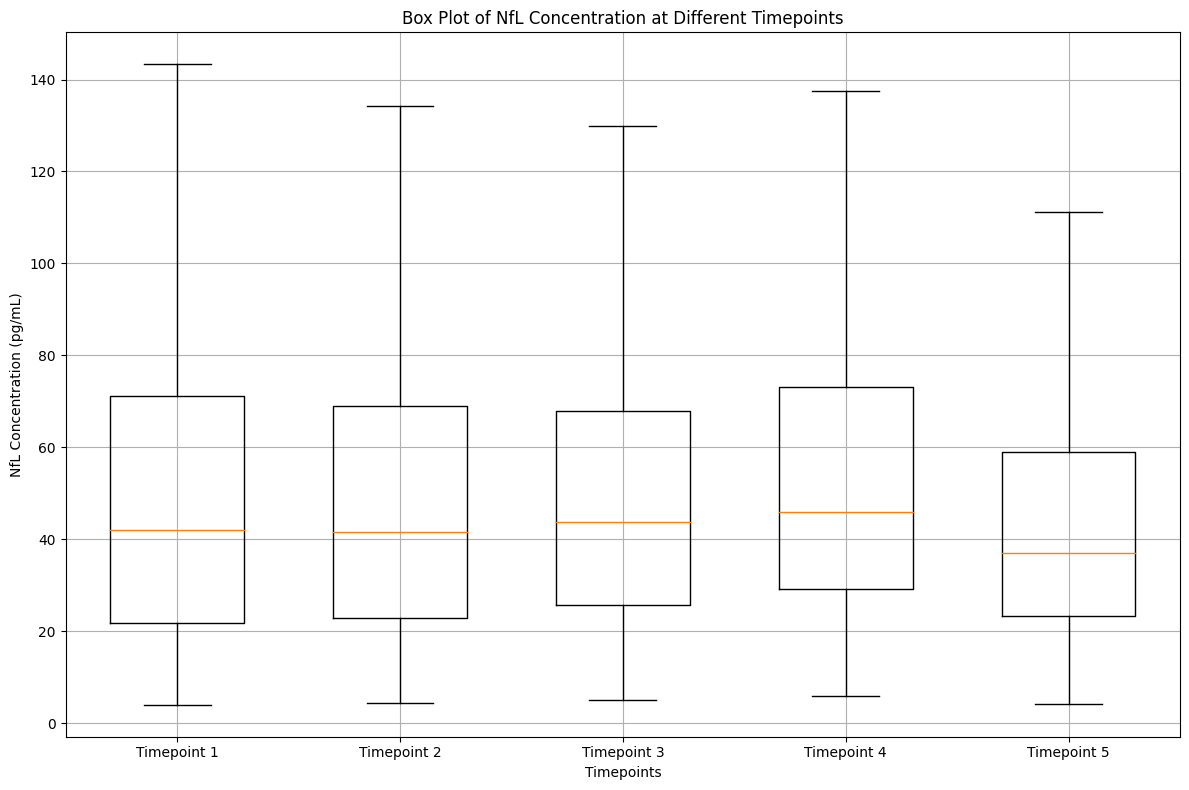

In [ ]:
# Initialize a figure for the plot
plt.figure(figsize=(12, 8))

# Plotting each timepoint data as a separate boxplot
for i in range(1, 6):
    timepoint_column = f'NfL_Concentration_(pg/mL)_at_Timepoint-{i}'
    timepoint_data = pd.to_numeric(df[timepoint_column].replace('Na', np.nan), errors='coerce')  # Convert 'Na' to NaN and then to numeric
    timepoint_data = timepoint_data.dropna()  # Drop NaN values from the numeric data
    plt.boxplot(timepoint_data, positions=[i], widths=0.6, showfliers=False)

# Set labels and title
plt.title('Box Plot of NfL Concentration at Different Timepoints')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6), [f'Timepoint {i}' for i in range(1, 6)])
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

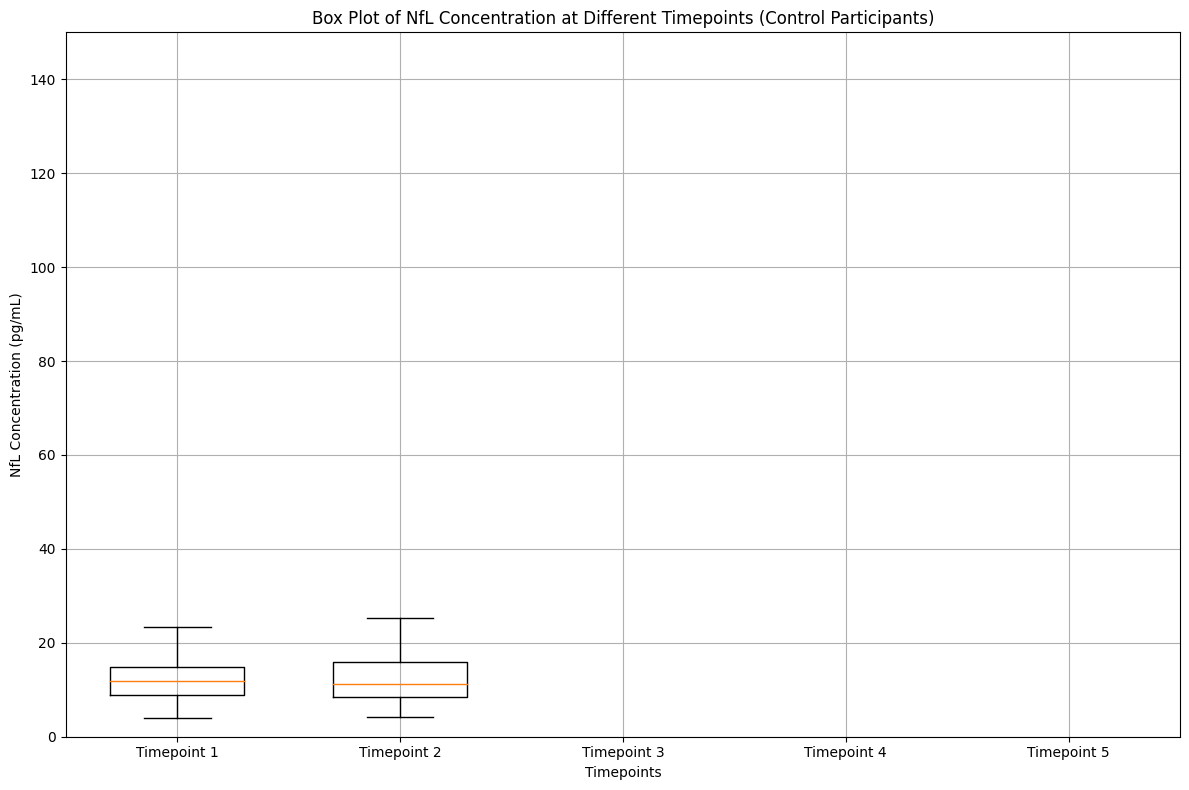

In [ ]:
plt.figure(figsize=(12, 8))

# Plotting each timepoint data as a separate boxplot for control patients
for i in range(1, 6):
    timepoint_column = f'NfL_Concentration_(pg/mL)_at_Timepoint-{i}'
    timepoint_data = pd.to_numeric(ctrl_df[timepoint_column].replace('Na', np.nan), errors='coerce')  # Convert 'Na' to NaN and then to numeric
    timepoint_data = timepoint_data.dropna()  # Drop NaN values from the numeric data
    plt.boxplot(timepoint_data, positions=[i], widths=0.6, showfliers=False)

# Set labels and title
plt.title('Box Plot of NfL Concentration at Different Timepoints (Control Participants)')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6), [f'Timepoint {i}' for i in range(1, 6)])

# Adjust y-axis limits and ticks
plt.ylim(0, 150)
plt.yticks(range(0, 151, 20))

plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

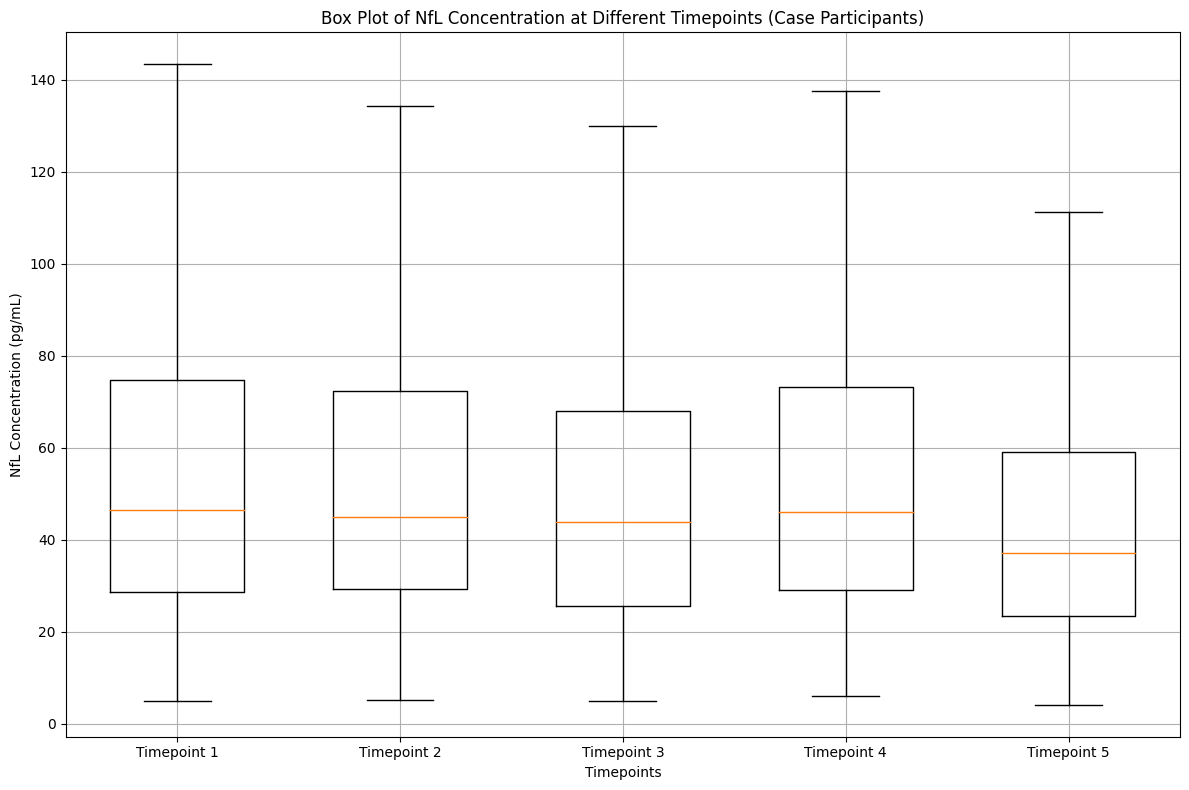

In [ ]:
plt.figure(figsize=(12, 8))

# Plotting each timepoint data as a separate boxplot for non-control patients
for i in range(1, 6):
    timepoint_column = f'NfL_Concentration_(pg/mL)_at_Timepoint-{i}'
    timepoint_data = pd.to_numeric(case_df[timepoint_column].replace('Na', np.nan), errors='coerce')  # Convert 'Na' to NaN and then to numeric
    timepoint_data = timepoint_data.dropna()  # Drop NaN values from the numeric data
    plt.boxplot(timepoint_data, positions=[i], widths=0.6, showfliers=False)

# Set labels and title
plt.title('Box Plot of NfL Concentration at Different Timepoints (Case Participants)')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6), [f'Timepoint {i}' for i in range(1, 6)])
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

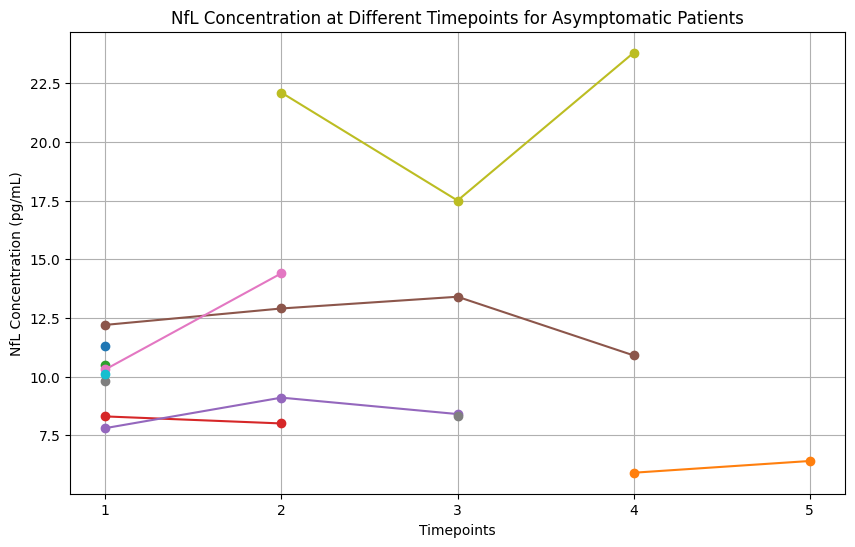

In [ ]:
plt.figure(figsize=(10, 6))

for index, row in case_df.iterrows():
    if row['HAS_NFL'] == 'Yes' and row['SUBJECT_GROUP'] == 'Asymptomatic ALS Gene carrier':
        values = row[timepoints_line].values
        # Convert values to numeric, coercing errors and ignoring non-numeric values
        numeric_values = pd.to_numeric(values, errors='coerce')
        plt.plot(range(1, 6), numeric_values, marker='o')

plt.title('NfL Concentration at Different Timepoints for Asymptomatic Patients')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

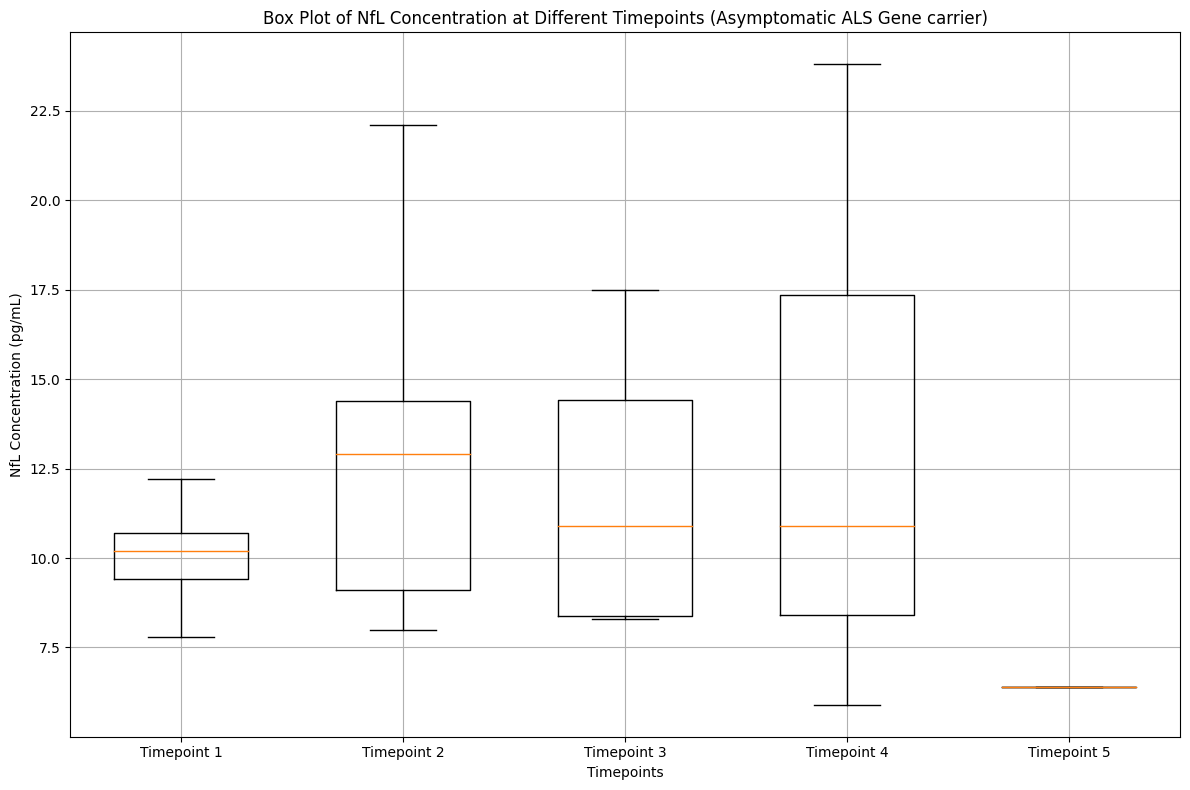

In [ ]:
asymptomatic_als_df = df[df['SUBJECT_GROUP'] == 'Asymptomatic ALS Gene carrier']

# Initialize a figure for the plot
plt.figure(figsize=(12, 8))

# Plotting each timepoint data as a separate boxplot for the filtered group
for i in range(1, 6):
    timepoint_column = f'NfL_Concentration_(pg/mL)_at_Timepoint-{i}'
    timepoint_data = pd.to_numeric(asymptomatic_als_df[timepoint_column].replace('Na', np.nan), errors='coerce')  # Convert 'Na' to NaN and then to numeric
    timepoint_data = timepoint_data.dropna()  # Drop NaN values from the numeric data
    plt.boxplot(timepoint_data, positions=[i], widths=0.6, showfliers=False)

# Set labels and title
plt.title('Box Plot of NfL Concentration at Different Timepoints (Asymptomatic ALS Gene carrier)')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks(range(1, 6), [f'Timepoint {i}' for i in range(1, 6)])
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

Average change in NfL values: 1.27 pg/mL


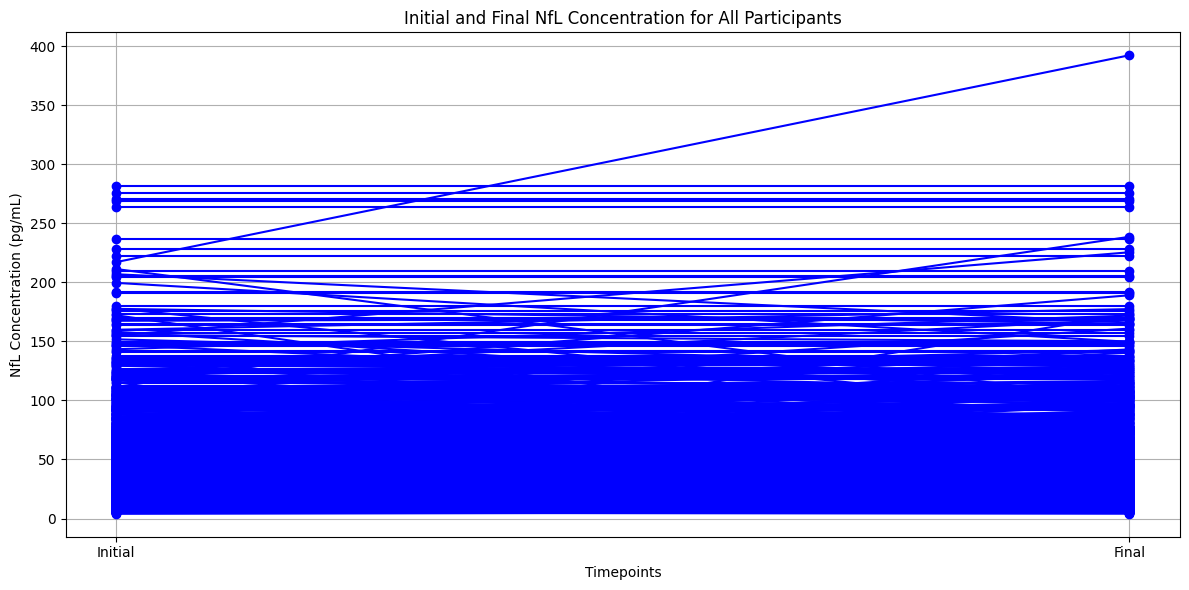

In [ ]:
plt.figure(figsize=(12, 6))

# Plot initial and final values
for index, row in df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')

        initial_value = next((x for x in numeric_values if not np.isnan(x)), np.nan)
        last_value = next((x for x in numeric_values[::-1] if not np.isnan(x)), np.nan)

        if not np.isnan(initial_value) and not np.isnan(last_value):
            plt.plot([1, 5], [initial_value, last_value], marker='o', linestyle='-', color='b')

plt.title('Initial and Final NfL Concentration for All Participants')
plt.xlabel('Timepoints')
plt.ylabel('NfL Concentration (pg/mL)')
plt.xticks([1, 5], ['Initial', 'Final'])
plt.grid(True)
plt.tight_layout()

# Calculate average change in NfL values
initial_values = []
final_values = []

for index, row in df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')

        initial_value = next((x for x in numeric_values if not np.isnan(x)), np.nan)
        last_value = next((x for x in numeric_values[::-1] if not np.isnan(x)), np.nan)

        if not np.isnan(initial_value) and not np.isnan(last_value):
            initial_values.append(initial_value)
            final_values.append(last_value)

average_change = np.mean(np.array(final_values) - np.array(initial_values))
print(f"Average change in NfL values: {average_change:.2f} pg/mL")

plt.show()

Creates a line graph for all patients NfL levels in log base 10

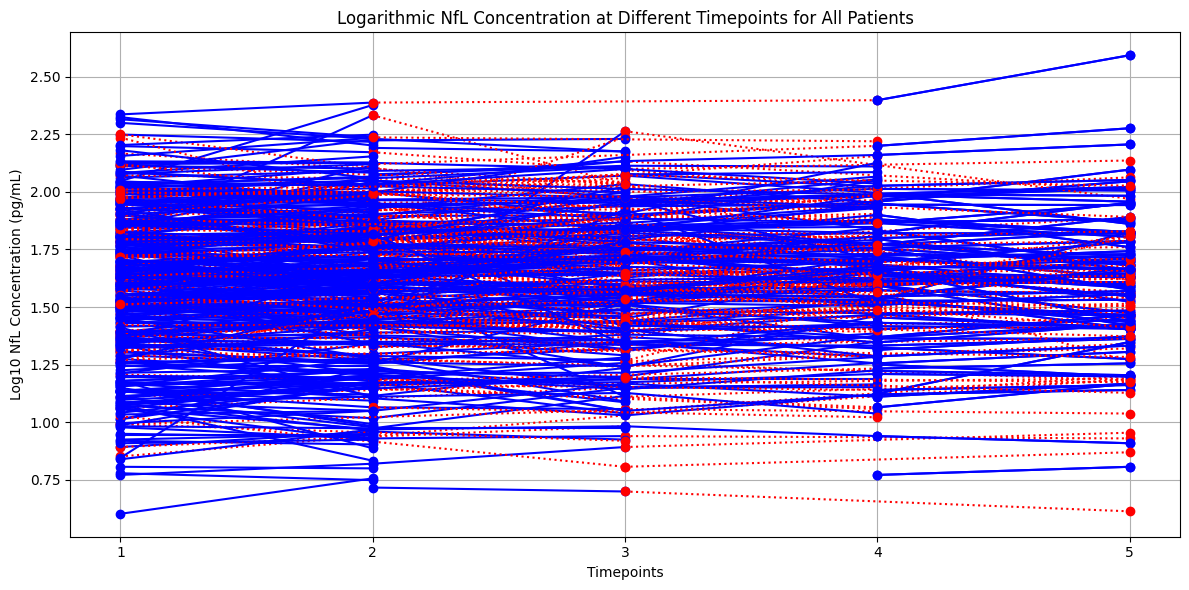

In [ ]:
plt.figure(figsize=(12, 6))

# Plot each patient's NfL levels
for index, row in df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')

        # Convert to log base 10
        numeric_values_log10 = np.log10(numeric_values)

        # Plot with dotted lines for missing data
        timepoints = range(1, 6)
        for i in range(len(numeric_values) - 1):
            if pd.notna(numeric_values_log10[i]) and pd.notna(numeric_values_log10[i + 1]):
                plt.plot(timepoints[i:i+2], numeric_values_log10[i:i+2], marker='o', linestyle='-', color='b')
            elif pd.notna(numeric_values_log10[i]) and pd.isna(numeric_values_log10[i + 1]) and i < len(numeric_values) - 2 and pd.notna(numeric_values_log10[i + 2]):
                plt.plot(timepoints[i:i+3:2], [numeric_values_log10[i], numeric_values_log10[i + 2]], marker='o', linestyle=':', color='r')

        # Plot the last segment if it exists
        if pd.notna(numeric_values_log10[-1]) and pd.notna(numeric_values_log10[-2]):
            plt.plot(timepoints[-2:], numeric_values_log10[-2:], marker='o', linestyle='-', color='b')

plt.title('Logarithmic NfL Concentration at Different Timepoints for All Patients')
plt.xlabel('Timepoints')
plt.ylabel('Log10 NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()

plt.show()

Log base 10 for all case patients

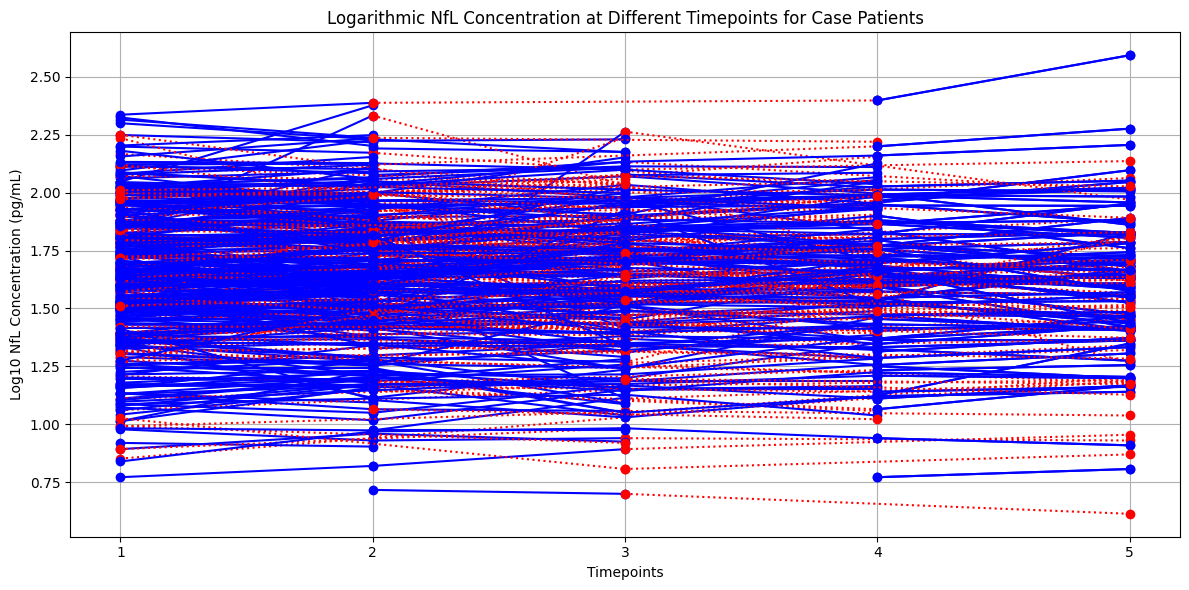

In [ ]:
plt.figure(figsize=(12, 6))

# Plot each patient's NfL levels
for index, row in case_df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')

        # Convert to log base 10
        numeric_values_log10 = np.log10(numeric_values)

        # Plot with dotted lines for missing data
        timepoints = range(1, 6)
        for i in range(len(numeric_values) - 1):
            if pd.notna(numeric_values_log10[i]) and pd.notna(numeric_values_log10[i + 1]):
                plt.plot(timepoints[i:i+2], numeric_values_log10[i:i+2], marker='o', linestyle='-', color='b')
            elif pd.notna(numeric_values_log10[i]) and pd.isna(numeric_values_log10[i + 1]) and i < len(numeric_values) - 2 and pd.notna(numeric_values_log10[i + 2]):
                plt.plot(timepoints[i:i+3:2], [numeric_values_log10[i], numeric_values_log10[i + 2]], marker='o', linestyle=':', color='r')

        # Plot the last segment if it exists
        if pd.notna(numeric_values_log10[-1]) and pd.notna(numeric_values_log10[-2]):
            plt.plot(timepoints[-2:], numeric_values_log10[-2:], marker='o', linestyle='-', color='b')

plt.title('Logarithmic NfL Concentration at Different Timepoints for Case Patients')
plt.xlabel('Timepoints')
plt.ylabel('Log10 NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()

plt.show()

Log base 10 for control patients

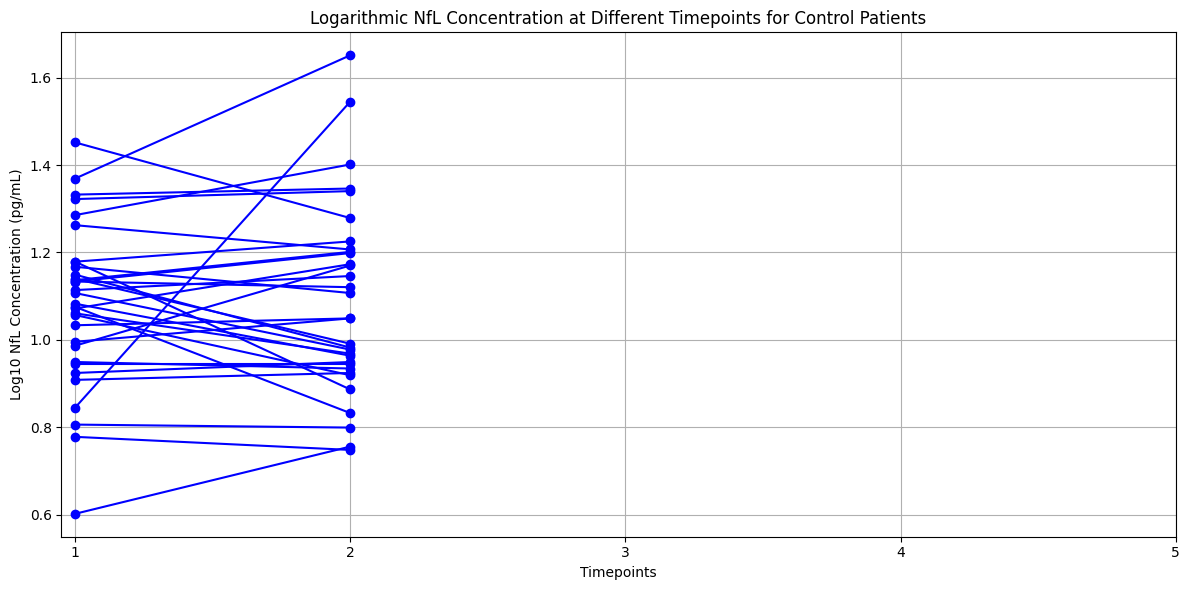

In [ ]:
plt.figure(figsize=(12, 6))

# Plot each patient's NfL levels
for index, row in ctrl_df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')

        # Convert to log base 10
        numeric_values_log10 = np.log10(numeric_values)

        # Plot with dotted lines for missing data
        timepoints = range(1, 6)
        for i in range(len(numeric_values) - 1):
            if pd.notna(numeric_values_log10[i]) and pd.notna(numeric_values_log10[i + 1]):
                plt.plot(timepoints[i:i+2], numeric_values_log10[i:i+2], marker='o', linestyle='-', color='b')
            elif pd.notna(numeric_values_log10[i]) and pd.isna(numeric_values_log10[i + 1]) and i < len(numeric_values) - 2 and pd.notna(numeric_values_log10[i + 2]):
                plt.plot(timepoints[i:i+3:2], [numeric_values_log10[i], numeric_values_log10[i + 2]], marker='o', linestyle=':', color='r')

        # Plot the last segment if it exists
        if pd.notna(numeric_values_log10[-1]) and pd.notna(numeric_values_log10[-2]):
            plt.plot(timepoints[-2:], numeric_values_log10[-2:], marker='o', linestyle='-', color='b')

plt.title('Logarithmic NfL Concentration at Different Timepoints for Control Patients')
plt.xlabel('Timepoints')
plt.ylabel('Log10 NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()

plt.show()

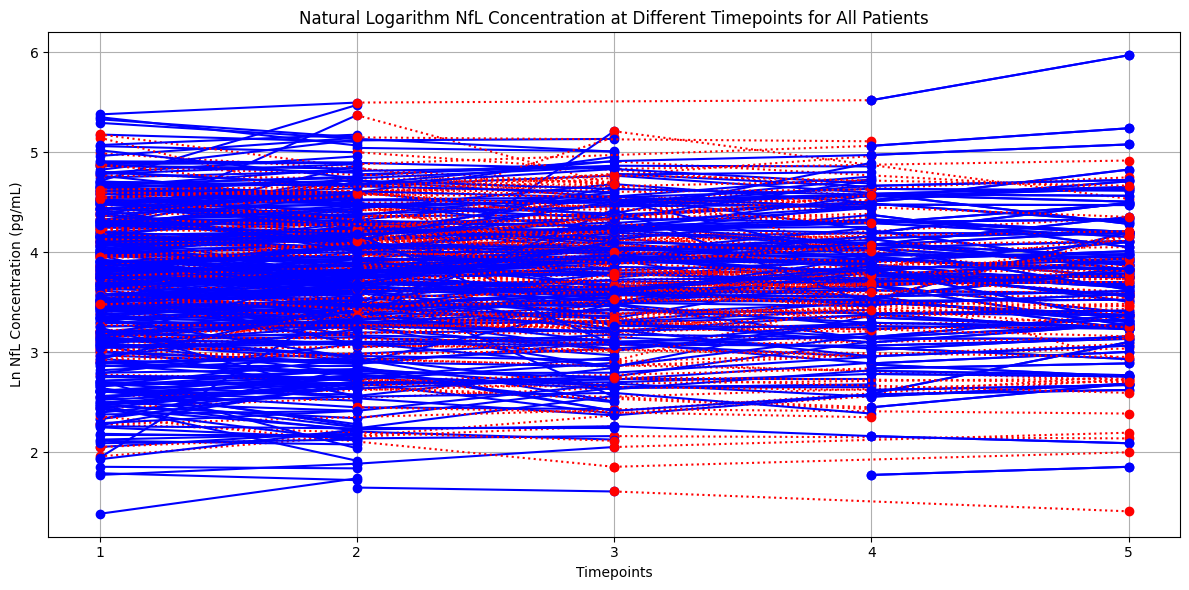

In [ ]:
plt.figure(figsize=(12, 6))

# Plot each patient's NfL levels
for index, row in df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')

        # Convert to natural logarithm (ln)
        numeric_values_ln = np.log(numeric_values)

        # Plot with dotted lines for missing data
        timepoints = range(1, 6)
        for i in range(len(numeric_values) - 1):
            if pd.notna(numeric_values_ln[i]) and pd.notna(numeric_values_ln[i + 1]):
                plt.plot(timepoints[i:i+2], numeric_values_ln[i:i+2], marker='o', linestyle='-', color='b')
            elif pd.notna(numeric_values_ln[i]) and pd.isna(numeric_values_ln[i + 1]) and i < len(numeric_values) - 2 and pd.notna(numeric_values_ln[i + 2]):
                plt.plot(timepoints[i:i+3:2], [numeric_values_ln[i], numeric_values_ln[i + 2]], marker='o', linestyle=':', color='r')

        # Plot the last segment if it exists
        if pd.notna(numeric_values_ln[-1]) and pd.notna(numeric_values_ln[-2]):
            plt.plot(timepoints[-2:], numeric_values_ln[-2:], marker='o', linestyle='-', color='b')

plt.title('Natural Logarithm NfL Concentration at Different Timepoints for All Patients')
plt.xlabel('Timepoints')
plt.ylabel('Ln NfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()

plt.show()

Each point represents an individual observation, with a line showing the trend of NfL changes at each timepoint. Mean values with standard deviations were calculated for NfL levels at each timepoint.

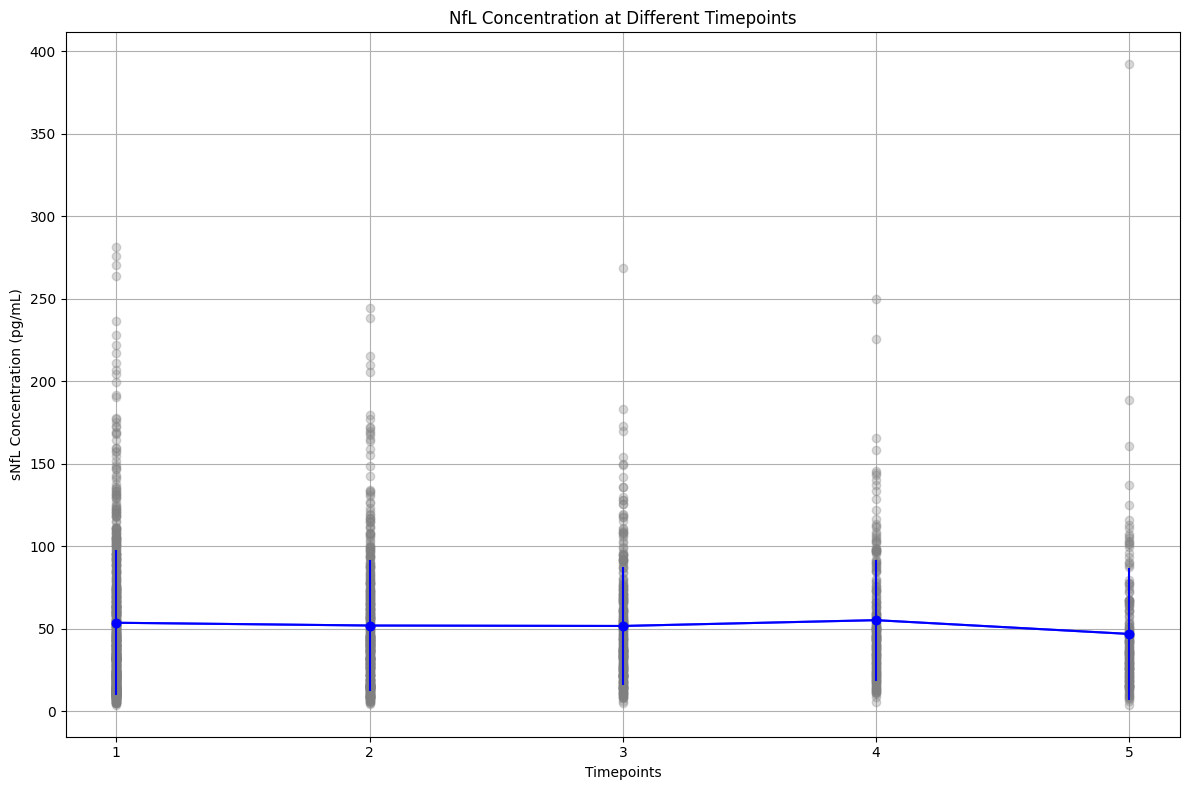

In [ ]:
# Calculate mean and standard deviation across all patients for each timepoint
mean_values = df[timepoints_line].apply(pd.to_numeric, errors='coerce').mean()
std_values = df[timepoints_line].apply(pd.to_numeric, errors='coerce').std()

plt.figure(figsize=(12, 8))

# Plot each individual observation
for index, row in df.iterrows():
    if row['HAS_NFL'] == 'Yes':
        values = row[timepoints_line].values
        numeric_values = pd.to_numeric(values, errors='coerce')

        # Plot individual observations with markers
        plt.plot(range(1, 6), numeric_values, marker='o', linestyle='', color='grey', alpha=0.3)

# Plot mean values with error bars (standard deviations)
plt.errorbar(range(1, 6), mean_values, yerr=std_values, fmt='-o', color='blue', label='Mean with Std Dev')

# Plot trend lines connecting mean values
plt.plot(range(1, 6), mean_values, marker='o', linestyle='-', color='blue', alpha=0.7, label='Mean Trend')

plt.title('NfL Concentration at Different Timepoints')
plt.xlabel('Timepoints')
plt.ylabel('sNfL Concentration (pg/mL)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()

plt.show()